In [28]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
  estimators=[
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, max_depth=4)),
    ('svc', SVC(random_state=42))
  ]
)

voting_clf.fit(X, y)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=4,
                                                     random_state=42)),
                             ('svc', SVC(random_state=42))])

# Ensemble 

In [25]:
for name, clf in voting_clf.named_estimators_.items():
  print (name, "=", clf.score(X_test, y_test))

voting_clf.score(X_test, y_test)

lr = 0.848
rf = 0.928
svc = 0.912


0.928

In [26]:
# Soft voting
voting_clf.voting = "soft"
# svc does not return probabilities by default 
voting_clf.named_estimators["svc"].probability = True
voting_clf = VotingClassifier(
  estimators=[
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, max_depth=4)),
    ('svc', SVC(random_state=42))
  ]
)
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)


0.912

# Bagging and Pasting

In [83]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# max_samples - the subset of the dataset to use when training each model
# bootstrap=False - use pasting instead of bagging.
# oob_score=True - do an out of bag evaluation during training
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500, 
                            max_samples=100, 
                            n_jobs=-1, 
                            oob_score=True,
                            random_state=42)

bag_clf.fit(X_train, y_train)
print (bag_clf.oob_score_)

12266.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12266.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12266.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12266.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12266.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12266.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12266.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12266.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12266.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12266.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that 

0.9253333333333333


In [84]:
# The OOB score is an average of each classifier's predictions on the samples it wasn't trained on (the out of bag samples).
# It should be close to the test score
bag_clf.score(X_test, y_test)

0.904

Text(0.5, 1.0, 'Ensemble classifier')

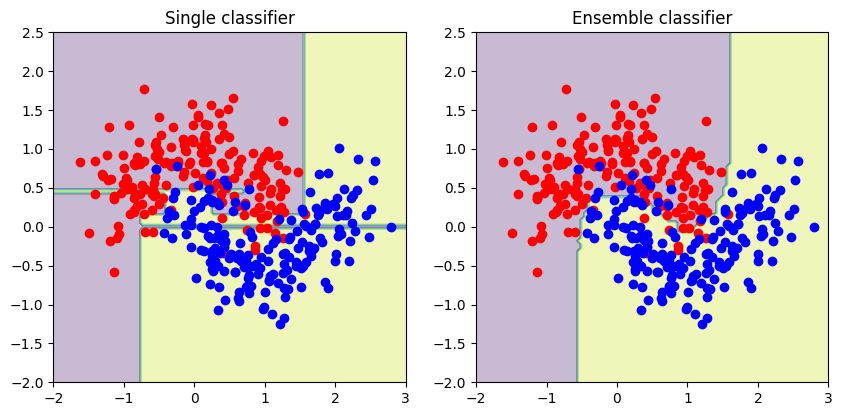

In [82]:
moons_0 = X_train[y_train == 0]
moons_1 = X_train[y_train == 1]

lengths, widths = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-2, 2.5, 100))
X_moons_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = bag_clf.estimators_[44].predict(X_moons_all).reshape(lengths.shape)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.contourf(lengths, widths, y_pred, alpha=0.3)
plt.scatter(moons_0[:,0], moons_0[:,1], color="red")
plt.scatter(moons_1[:,0], moons_1[:,1], color="blue")
plt.title("Single classifier")

y_pred = bag_clf.predict(X_moons_all).reshape(lengths.shape)
plt.subplot(2, 2, 2)
plt.contourf(lengths, widths, y_pred, alpha=0.3)
plt.scatter(moons_0[:,0], moons_0[:,1], color="red")
plt.scatter(moons_1[:,0], moons_1[:,1], color="blue")
plt.title("Ensemble classifier")



# Feature Importance

In [85]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)


RandomForestClassifier(n_estimators=500, random_state=42)

In [87]:
for name, score in zip(iris.data.columns, rnd_clf.feature_importances_):
  print (f"{name}: {score}")


sepal length (cm): 0.11249225099876375
sepal width (cm): 0.02311928828251033
petal length (cm): 0.4410304643639577
petal width (cm): 0.4233579963547682


# Boosting

### AdaBoost

In [89]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
  DecisionTreeClassifier(max_depth=1), n_estimators=30,
  learning_rate=0.5, random_state=42
)

ada_clf.fit(X_train, y_train)
ada_clf.score(X_test, y_test)

0.904

### Gradient Boosting

In [93]:
from sklearn.tree import DecisionTreeRegressor


np.random.seed(42)

X = np.random.rand(100, 1) - 0.5

# y = 3x^2 + gaussian noise
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

# First learner
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# Second learner's y is affected by previous learner predictions. This is called the residual error of learner 1
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# Third learner gets the residuals of previous learner and so on...
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

# To make a prediction, we sum all 3 predictions 
X_new = np.array([[0.4]])
print ("Prediction: ", sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)))
print ("Actual: ", 3 * X_new ** 2 + 0.05 * np.random.randn(1))


Prediction:  [0.49995198]
Actual:  [[0.48065009]]


In [126]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1, random_state=42)
gbrt.fit(X,y)
print (gbrt.predict(X_new))


gbrt_overfit = GradientBoostingRegressor(max_depth=2, n_estimators=500, learning_rate=0.05, random_state=42)
gbrt_overfit.fit(X,y)
print (gbrt_overfit.predict(X_new))

# n_iter_no_change - stop adding trees if there was no improvement after n attempts. Similar to early stopping. Helps
# prevent overfitting
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=500, learning_rate=0.05, n_iter_no_change=10, random_state=42)
gbrt_best.fit(X,y)
print (gbrt_best.predict(X_new))

[0.49995198]
[0.46253894]
[0.5319372]


Text(0.5, 1.0, 'Best boosting')

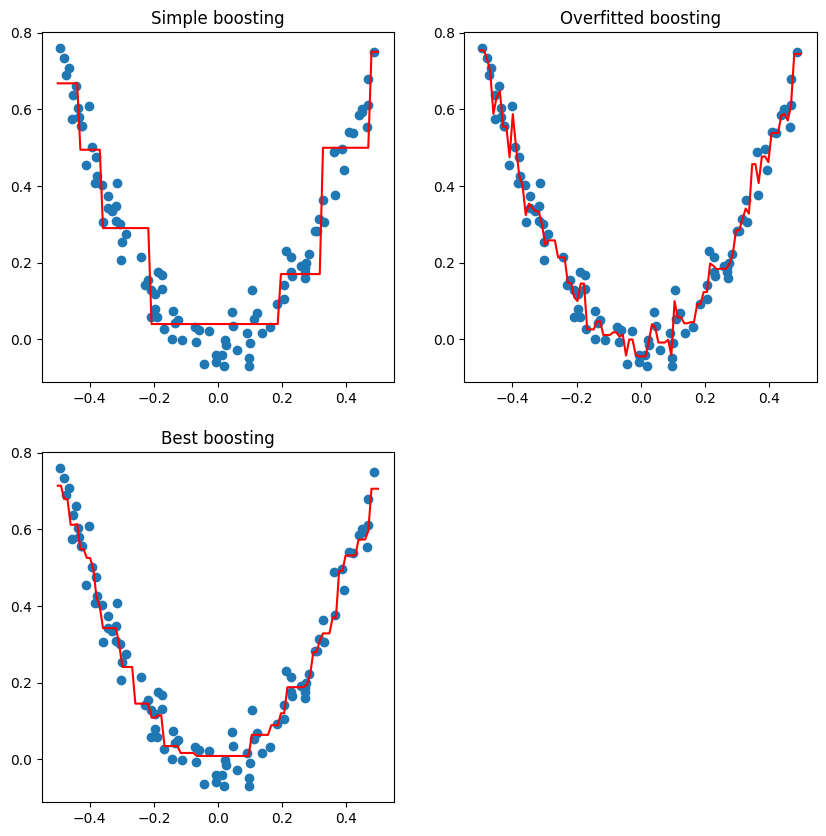

In [133]:
plt.figure(figsize=(10,10))

X_new_all = np.linspace(-0.5, 0.5, 100).reshape(-1,1)
y_pred = gbrt.predict(X_new_all)
plt.subplot(2,2,1)
plt.scatter(X, y)
plt.plot(X_new_all, y_pred, color="red")
plt.title("Simple boosting")

y_pred_overfit = gbrt_overfit.predict(X_new_all)
plt.subplot(2,2,2)
plt.scatter(X, y)
plt.plot(X_new_all, y_pred_overfit, color="red")
plt.title("Overfitted boosting")


y_pred_best = gbrt_best.predict(X_new_all)
plt.subplot(2,2,3)
plt.scatter(X, y)
plt.plot(X_new_all, y_pred_best, color="red")
plt.title("Best boosting")

